In [86]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [2]:
def prepare_data(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )
    return ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
metadata = pd.read_csv('data/Chest_xray_Corona_Metadata.csv').drop('Unnamed: 0', axis=1)
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [69]:
metadata['Label'].value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

In [ ]:
image_root_path = 'data/'

In [3]:
batch_size = 50
input_shape = (224, 224, 3)
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
train_data = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    batch_size=50,
    image_size=input_shape[:2],
    seed=0,
    validation_split=0.2,
    subset='training'
)

Found 5286 files belonging to 2 classes.
Using 4229 files for training.


In [6]:
validation_data = image_dataset_from_directory(
    'data/train/',
    labels='inferred',
    batch_size=50,
    image_size=input_shape[:2],
    seed=0,
    validation_split=0.2,
    subset='validation'
)

Found 5286 files belonging to 2 classes.
Using 1057 files for validation.


In [7]:
test_data = image_dataset_from_directory(
    'data/test/',
    labels='inferred',
    image_size=input_shape[:2]
)

Found 624 files belonging to 2 classes.


In [8]:
data_augmentation = tf.keras.Sequential([
layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
layers.experimental.preprocessing.RandomRotation(0.2),
layers.experimental.preprocessing.RandomHeight(0.1),
layers.experimental.preprocessing.RandomWidth(0.1),
layers.experimental.preprocessing.RandomZoom(0.1),
])

In [9]:
# train_data = prepare_data(train_data, shuffle=True, augment=True)
# validation_data = prepare_data(validation_data)
# test_data = prepare_data(test_data)
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
validation_data = validation_data.map(lambda x, y: (preprocess_input(x), y))
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))
train_data_pf = train_data.prefetch(buffer_size=AUTOTUNE)
validation_data_pf = validation_data.prefetch(buffer_size=AUTOTUNE)
test_data_pf = test_data.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Calculate class weights to balance data
unique_classes = metadata.Label.unique()
all_rows = metadata.Label.to_numpy()
weights = compute_class_weight('balanced', classes=unique_classes, y=all_rows)

In [72]:
# set initial output bias for model to speed up convergence
initial_bias = Constant(weights[1] / weights[0])

In [74]:
densenet_model = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

densenet_model.trainable = False
densenet_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block39_1_conv (Conv2D)   (None, 14, 14, 128)  188416      conv4_block39_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block39_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block39_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block39_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block39_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block39_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block39_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block39_concat (Concatena (None, 14, 14, 1504) 0           conv4_block38_concat[0][0]       
          

In [75]:
def create_model():
    model = Sequential()
    model.add(data_augmentation)
    model.add(densenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', bias_initializer=initial_bias))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [91]:
model = create_model()

In [92]:
checkpoint = ModelCheckpoint(
    'model checkpoints/',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1
)

In [93]:
history = model.fit(
    train_data,
    batch_size=50,
    callbacks=[checkpoint, early_stopping],
    epochs=10,
    validation_data=validation_data,
    verbose=1
)

Epoch 1/10
85/85 [==============================] - 67s 527ms/step - loss: 0.3805 - accuracy: 0.8349 - val_loss: 0.2876 - val_accuracy: 0.8694
Epoch 2/10
85/85 [==============================] - 43s 485ms/step - loss: 0.2428 - accuracy: 0.9047 - val_loss: 0.2411 - val_accuracy: 0.8931
Epoch 3/10
85/85 [==============================] - 41s 467ms/step - loss: 0.2069 - accuracy: 0.9179 - val_loss: 0.2037 - val_accuracy: 0.9215
Epoch 4/10
85/85 [==============================] - 43s 484ms/step - loss: 0.1892 - accuracy: 0.9260 - val_loss: 0.1944 - val_accuracy: 0.9196
Epoch 5/10
85/85 [==============================] - 42s 475ms/step - loss: 0.1742 - accuracy: 0.9347 - val_loss: 0.1817 - val_accuracy: 0.9272
Epoch 6/10
85/85 [==============================] - 42s 472ms/step - loss: 0.1719 - accuracy: 0.9343 - val_loss: 0.1871 - val_accuracy: 0.9177


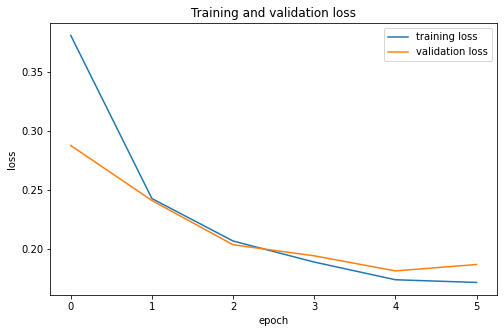

In [97]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.show()

In [98]:
model.load_weights('model checkpoints/')

In [99]:
y_pred = model.predict(test_data)

In [100]:
iterator = iter(test_data)
y_test = np.array([])
for i in iterator:
    y_test = np.concatenate([y_test, i[1].numpy()])

In [101]:
y_pred = np.where(y_pred >= 0.5, 1, 0)

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.12      0.18       234
         1.0       0.62      0.85      0.71       390

    accuracy                           0.58       624
   macro avg       0.47      0.49      0.45       624
weighted avg       0.51      0.58      0.51       624



In [103]:
y_pred.mean()

0.8589743589743589

In [105]:
y_test.mean()

0.625

In [106]:
iterator = iter(train_data)
y_train = np.array([])
for i in iterator:
    y_train = np.concatenate([y_train, i[1].numpy()])

In [107]:
iterator = iter(validation_data)
y_val = np.array([])
for i in iterator:
    y_val = np.concatenate([y_val, i[1].numpy()])

In [108]:
y_train.mean()

0.7446204776542918

In [109]:
y_val.mean()

0.7521286660359509